## Study if x parameter (L.._x columns) affects average user count in network

Study how a change in cell specific parameter value “_x” affects the
average user count in the network

Dataset specifics:
- Columns ending in "_x" are the x parameter for a cell
- Columns not ending in "_x" but which have the format "L(number)" are the average user count for that cell during time of measurement 
- First rows are datetime info

How to check if the x parameter affects average user count:
<br>
    1. Treat user count over the network as a whole and x parameter cells as a whole and do plotting
<br>
    2. If somethign interesting is found try to find out if there is a correlation'
    

Assumptions of task:
 - The network as specified in the task means all the measured nodes
 - The candidate columns e.g. engind in x can be measured together as a whole even though assignment refers to them as cell specific parameters
 

Tools used: 
pandas

In [250]:
import pandas as pd
import matplotlib.pyplot as plt
cell_data = pd.read_csv('users.csv', sep=';')

In [251]:
# helper functions

In [252]:
def get_candidate_column_names(df):
    candidate_columns = [column for column in df.columns if column[-1]==('x')]
    return candidate_columns

In [253]:
def get_user_count_column_names(df, candidate_columns):
    all_except_candidate = [column for column in df.columns if column not in candidate_columns]
    other_excluded_cols = ['Time', 'Day', 'Hour', 'Rownum',]
    user_count_columns = [column for column in all_except_candidate if column not in other_excluded_cols]
    return user_count_columns

In [254]:
def comma_string_to_float(string_with_comma):
    return float(string_with_comma.replace(',', '.'))

In [255]:
# separate columns to categories
candidate_columns = get_candidate_column_names(cell_data)
not_relevant_columns = ['L1022212_x', 'L1100545_x', 'L1132034_x', 'L264453_x', 'L264454_x']
candidate_columns_that_change = [column for column in candidate_columns if column not in not_relevant_columns]
user_count_columns = get_user_count_column_names(cell_data, candidate_columns)

In [256]:
# user count data needs to be cleaned and converted into floats
for column in user_count_columns:
    cell_data[column] = cell_data[column].apply(comma_string_to_float)

In [261]:
# aggregate mean of all candidate column rows
cell_data['candidate_x_mean_relevant'] = cell_data[candidate_columns_that_change].agg('mean', axis=1)
cell_data['candidate_x_mean'] = cell_data[candidate_columns].agg('mean', axis=1)
cell_data['average_user_count_sum'] = cell_data[user_count_columns].agg('sum', axis=1)

In [262]:
# convert timestamp to readable time
cell_data['datetime'] = pd.to_datetime(cell_data["Time"], unit='s')

<AxesSubplot:xlabel='datetime'>

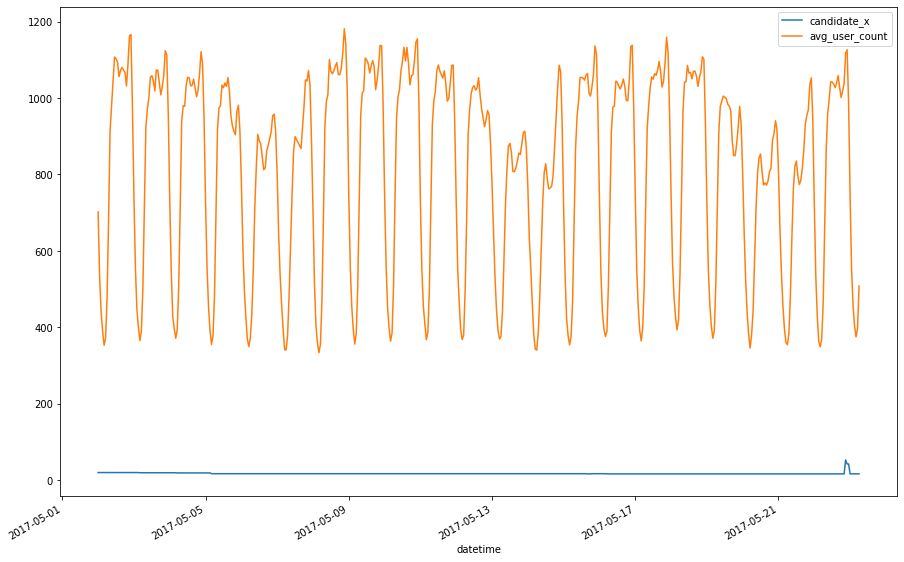

In [318]:
df = pd.DataFrame()
df['candidate_x'] = cell_data['candidate_x_mean_relevant']
df['avg_user_count'] = cell_data['average_user_count_sum']
df['datetime'] = cell_data['datetime']

df.plot(x='datetime', figsize=(15,10))

From the above graph you can see that there is no visually significant impact on the x values on the whole networks users. 
Maybe when the x value drops for one cell that cells user count goes down, but it's still adjusted on the full network.

In [277]:
# try to compare pct change instead of the values
cell_data['candidate_x_pct'] = cell_data['candidate_x_mean_relevant'].pct_change()
cell_data['average_user_count_pct'] = cell_data['average_user_count_sum'].pct_change()

<AxesSubplot:xlabel='datetime'>

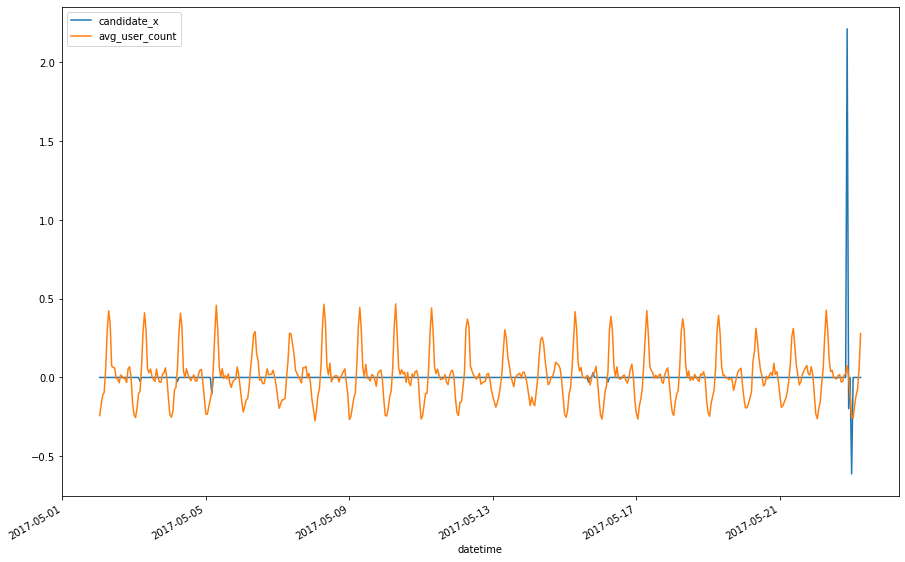

In [278]:
df2 = pd.DataFrame()
df2['candidate_x'] = cell_data['candidate_x_pct']
df2['avg_user_count'] = cell_data['average_user_count_pct']
df2['datetime'] = cell_data['datetime']

df2.plot(x='datetime', figsize=(15,10))

In [279]:
# lets check a scatter plot

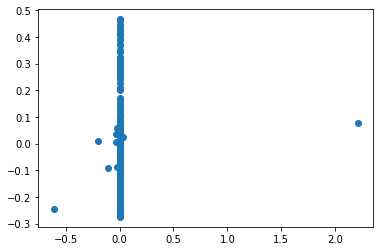

In [280]:
import matplotlib.pyplot as plt
plt.scatter(cell_data['candidate_x_pct'], cell_data['average_user_count_pct'])

In [281]:
#get correlation
corr = cell_data['candidate_x_pct'].corr(cell_data['average_user_count_pct'])

In [282]:
corr

0.041268535696085865

As above stated there is no significant correlation between the mean of X parameter and the average user count of the whole network.


In [302]:
# try to do some normalisation, prepare data for ML process if needed. However, normalisation does not effect the results since it only adjusts scale
df3 = pd.DataFrame()
df3['candidate_x_mean'] = cell_data['candidate_x_mean_relevant']
df3['average_user_count'] = cell_data['average_user_count_sum']

In [284]:
from sklearn import preprocessing
cell_data_array = preprocessing.normalize(df3, axis=0)
cell_data_normalized = pd.DataFrame(cell_data_array, columns=df3.columns)

In [285]:
cell_data_normalized['datetime'] = cell_data['datetime']

<AxesSubplot:xlabel='datetime'>

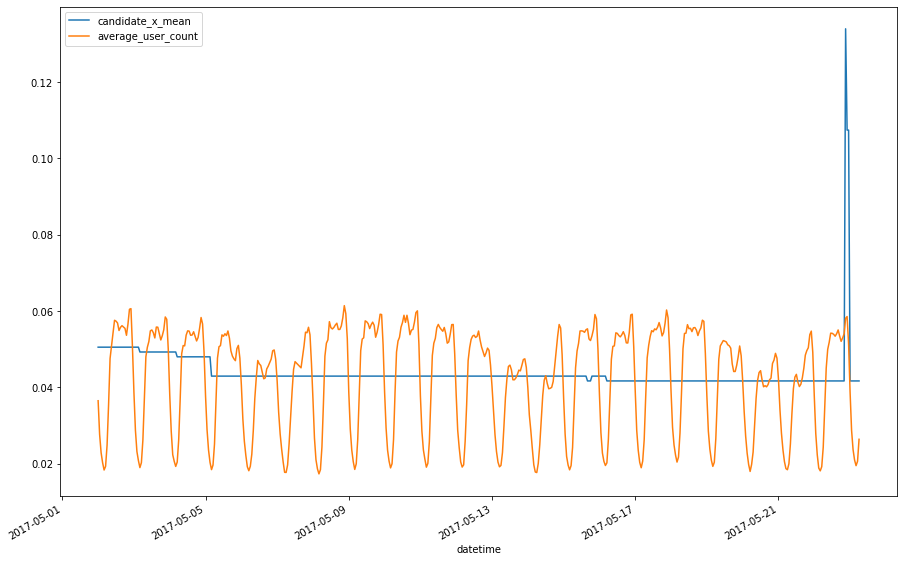

In [286]:
# try to plot
cell_data_normalized.plot(x='datetime', figsize=(15,10))

As stated normalisation does not change the results but graph looks better with one scale

In [292]:
# Checking the return value of the changes over time as a santiy check 
cell_data_normalized['candidate_x_mean_return'] = cell_data_normalized['candidate_x_mean'].pct_change()
cell_data_normalized['average_user_count_return'] = cell_data_normalized['average_user_count'].pct_change()

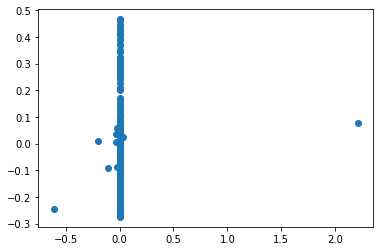

In [293]:
plt.scatter(cell_data_normalized['candidate_x_mean_return'], cell_data_normalized['average_user_count_return'])

In [289]:
corr = cell_data_normalized['candidate_x_mean_return'].corr(cell_data_normalized['average_user_count_return'])

In [290]:
corr

0.04126853569608588

Correlation is as without normalisation the same as it should be

Study further:
<br>
When studying the whole network and usign the mean for the X parameter does not seems to have any correlation so the effects of X might be too subtle to tell this way. Lets try to check only one columns e.g. target column L1547777 and corresponding x column

In [320]:
#test only target column and target x for sanity check
df4 = pd.DataFrame()
df4['datetime'] = cell_data['datetime']
df4['L1547777'] = cell_data['L1547777']
df4['L1547777_x'] = cell_data['L1547777_x']

<AxesSubplot:xlabel='datetime'>

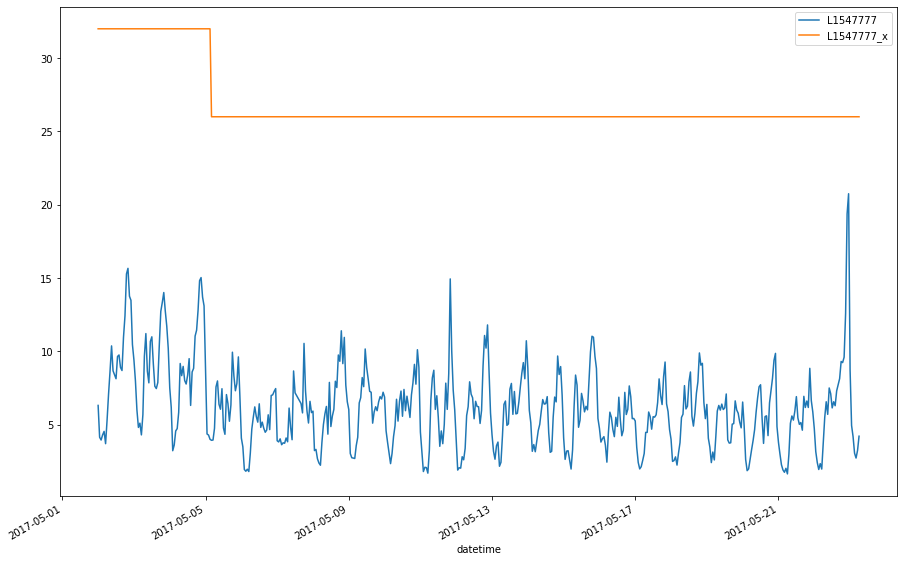

In [321]:
df4.plot(x='datetime', figsize=(15,10))

Only 1 change in the X parameter over the whole time series. At a quick glance you can see that before the drop the highs were higher and after the drop the highs were generally lower except for two outliers. 

<AxesSubplot:xlabel='datetime'>

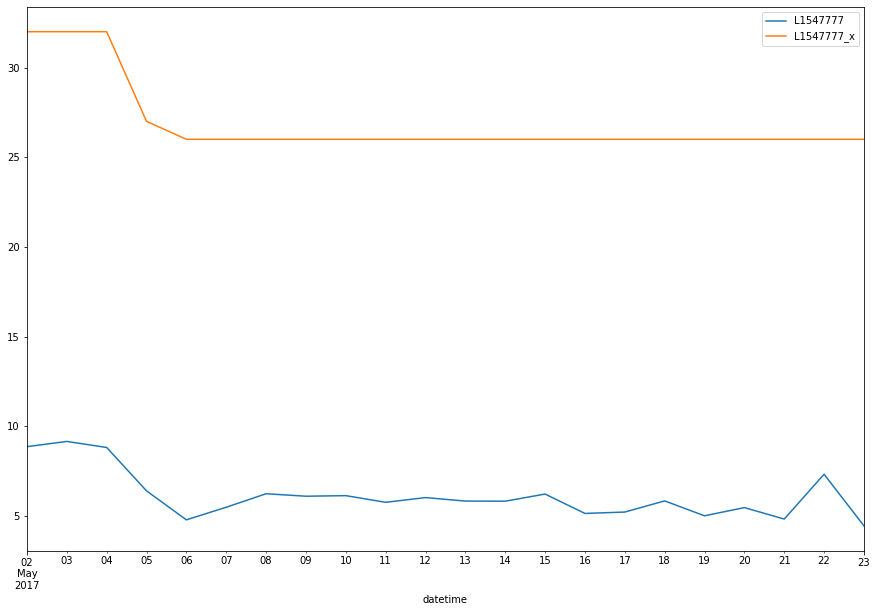

In [346]:
grouped_by_day = df4.resample('D', on='datetime').mean()
grouped_by_day.plot(figsize=(15,10))

In [362]:
corr = grouped_by_day['L1547777_x'].corr(grouped_by_day['L1547777'])
corr

0.8810694275597725

Ok, so there seems to be quite a good correlation between the two values here. 

In [348]:
df5 = pd.DataFrame()
df5['L1547777_ret'] = grouped_by_day['L1547777'].pct_change()
df5['L1547777_x_ret'] = grouped_by_day['L1547777_x'].pct_change() 

<AxesSubplot:xlabel='datetime'>

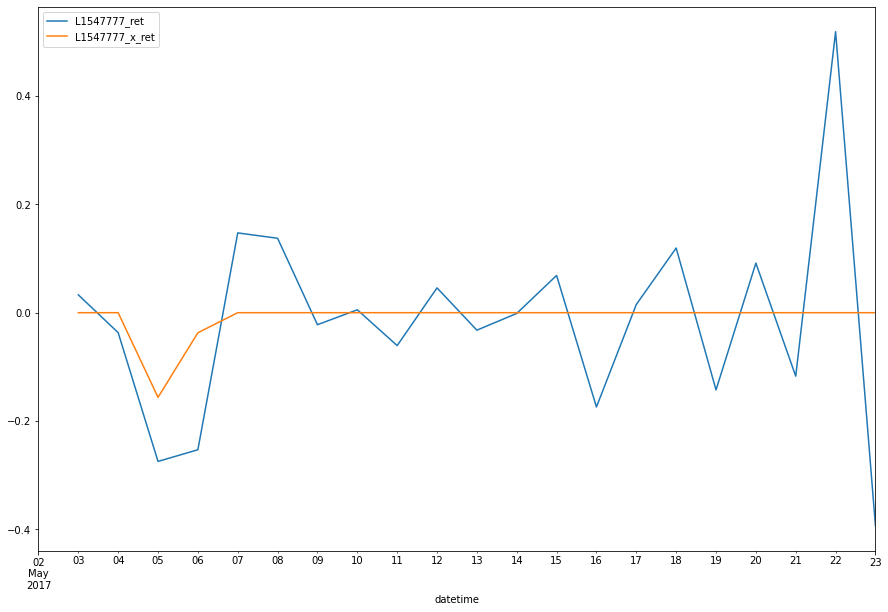

In [363]:
df5.plot(figsize=(15,10))

In [357]:
corr = df5['L1547777_ret'].corr(df5['L1547777_x_ret'])
corr

0.37992933974278986

There is a bit higher correlation between x values and average user count in this one column. However, its still quite weaker than before. 

## Results

My first test was to see if all the x parameters have aany effect on the average user count on the whole network. They didnt have an affect with a low correlation.

I then tested only target column and corresponding X parameter. There was a big dip in the x parameter and a simulataneous dip in the user count. After grouping by day to get a more smooth curve the relations were more visible. Correlation is at 0.88 which is quite high. 

So to conclude it seems a single columns x parameter has an effect on the columns daily average user count. E.g. if the X parameter is lower the average user count is on lower. The x parameters dont have a significant effect on the whole network. It seems the network corrects for one cells drops. Further study is needed if this applies to all cells. 